# Tutorial 2: Advanced Initialization - Variance Scaling and Orthogonal Methods

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/braintools/blob/main/docs/init_tutorial_02_variance_scaling_orthogonal.ipynb)

This tutorial covers advanced weight initialization strategies that are essential for training deep neural networks effectively. These methods automatically scale initialization based on network architecture to maintain stable gradient flow.

## Topics Covered

1. **Variance scaling principles** for deep networks
2. **Kaiming/He initialization** for ReLU networks
3. **Xavier/Glorot initialization** for tanh/sigmoid
4. **LeCun initialization** for SELU
5. **Orthogonal initialization** for RNNs and deep CNNs
6. **Identity initialization**
7. **Fan modes explained**: fan-in, fan-out, fan-avg

## Installation and Setup

In [25]:
# Install braintools if needed
# !pip install braintools brainunit matplotlib numpy jax

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import brainunit as u
from braintools import init
import jax.numpy as jnp

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

## 1. Variance Scaling Principles

### The Problem: Vanishing and Exploding Gradients

In deep networks, improper initialization can cause:
- **Vanishing gradients**: Signals become too small as they propagate
- **Exploding gradients**: Signals become too large as they propagate

Both problems make training difficult or impossible.

### The Solution: Variance Scaling

Variance scaling methods initialize weights based on the network's **fan-in** (number of input units) and/or **fan-out** (number of output units) to maintain signal variance across layers.

**Key principle**: Initialize weights so that:
- Forward pass: activations maintain similar variance
- Backward pass: gradients maintain similar variance

### Mathematical Foundation

For a linear layer with input $x$ and weights $W$:

$$y = Wx$$

The variance of the output is:

$$\text{Var}(y) = n_{in} \cdot \text{Var}(w) \cdot \text{Var}(x)$$

To maintain $\text{Var}(y) = \text{Var}(x)$, we need:

$$\text{Var}(w) = \frac{1}{n_{in}}$$

### Visualizing the Gradient Problem

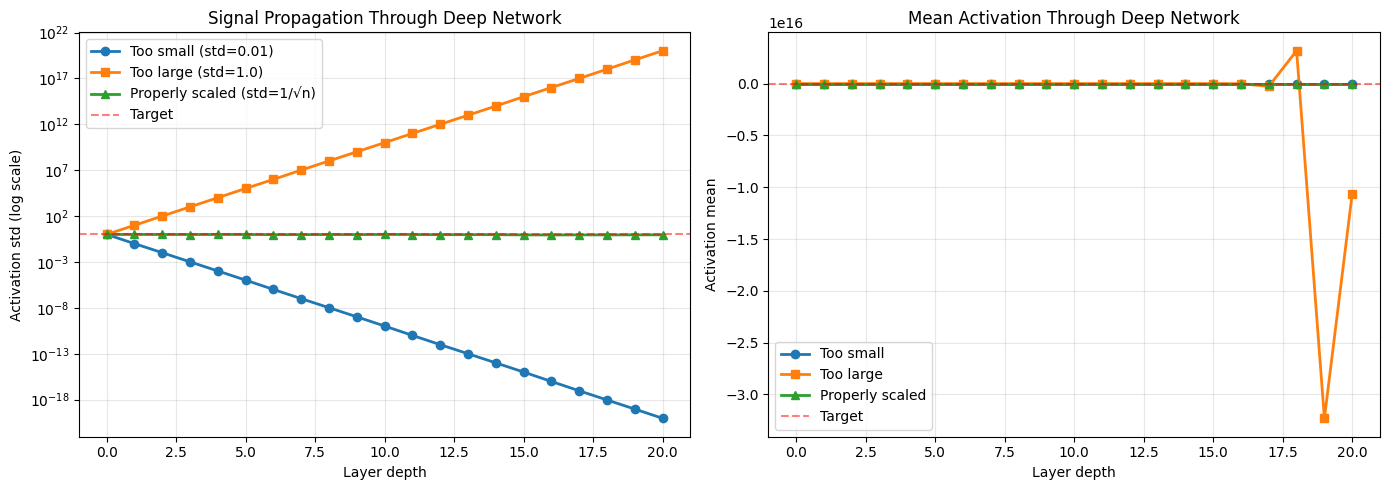


⚠️ Problems with improper initialization:
  Too small: Final std = 9.12e-21 (vanishing signals)
  Too large: Final std = 1.05e+20 (exploding signals)
  Properly scaled: Final std = 0.90 (stable signals)


In [27]:
def simulate_forward_pass(n_layers, n_units, init_std, activation='linear'):
    """
    Simulate forward pass through a deep network.
    """
    # Initialize input
    x = np.random.randn(1000, n_units)
    
    # Track activation statistics
    means = [x.mean()]
    stds = [x.std()]
    
    for layer in range(n_layers):
        # Weight matrix
        W = np.random.randn(n_units, n_units) * init_std
        
        # Forward pass
        x = x @ W
        
        # Apply activation
        if activation == 'relu':
            x = np.maximum(0, x)
        elif activation == 'tanh':
            x = np.tanh(x)
        
        means.append(x.mean())
        stds.append(x.std())
    
    return means, stds

# Compare different initialization scales
n_layers = 20
n_units = 100

# Too small initialization
means_small, stds_small = simulate_forward_pass(n_layers, n_units, 0.01)

# Too large initialization
means_large, stds_large = simulate_forward_pass(n_layers, n_units, 1.0)

# Properly scaled initialization
means_good, stds_good = simulate_forward_pass(n_layers, n_units, 1.0 / np.sqrt(n_units))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard deviation across layers
layers = np.arange(len(stds_small))
axes[0].semilogy(layers, stds_small, 'o-', label='Too small (std=0.01)', linewidth=2)
axes[0].semilogy(layers, stds_large, 's-', label='Too large (std=1.0)', linewidth=2)
axes[0].semilogy(layers, stds_good, '^-', label='Properly scaled (std=1/√n)', linewidth=2)
axes[0].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Target')
axes[0].set_xlabel('Layer depth')
axes[0].set_ylabel('Activation std (log scale)')
axes[0].set_title('Signal Propagation Through Deep Network')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Mean across layers
axes[1].plot(layers, means_small, 'o-', label='Too small', linewidth=2)
axes[1].plot(layers, means_large, 's-', label='Too large', linewidth=2)
axes[1].plot(layers, means_good, '^-', label='Properly scaled', linewidth=2)
axes[1].axhline(0.0, color='red', linestyle='--', alpha=0.5, label='Target')
axes[1].set_xlabel('Layer depth')
axes[1].set_ylabel('Activation mean')
axes[1].set_title('Mean Activation Through Deep Network')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ Problems with improper initialization:")
print(f"  Too small: Final std = {stds_small[-1]:.2e} (vanishing signals)")
print(f"  Too large: Final std = {stds_large[-1]:.2e} (exploding signals)")
print(f"  Properly scaled: Final std = {stds_good[-1]:.2f} (stable signals)")

## 2. Fan Modes Explained

Before diving into specific methods, let's understand the **fan** concept:

### Fan-in and Fan-out

For a weight matrix $W$ of shape $(n_{out}, n_{in})$:
- **Fan-in** ($n_{in}$): Number of input connections to each neuron
- **Fan-out** ($n_{out}$): Number of output connections from each neuron
- **Fan-avg**: Average of fan-in and fan-out: $(n_{in} + n_{out}) / 2$

### Which mode to use?

- **fan_in**: Focus on forward pass stability (Kaiming, LeCun)
- **fan_out**: Focus on backward pass (gradient) stability
- **fan_avg**: Balance between forward and backward (Xavier/Glorot)

For higher-dimensional tensors (e.g., convolution kernels):
- **Receptive field size** is also considered
- Example: Conv2D kernel of shape $(C_{out}, C_{in}, H, W)$
  - fan_in = $C_{in} \times H \times W$
  - fan_out = $C_{out} \times H \times W$


Fan Computation Examples:
        Layer Type           Shape  Fan-in  Fan-out  Fan-avg
      Dense 100→50       (50, 100)     100       50     75.0
      Dense 50→100       (100, 50)      50      100     75.0
 Conv2D 3×3, 16→32  (32, 16, 3, 3)     144      288    216.0
Conv2D 5×5, 64→128 (128, 64, 5, 5)    1600     3200   2400.0


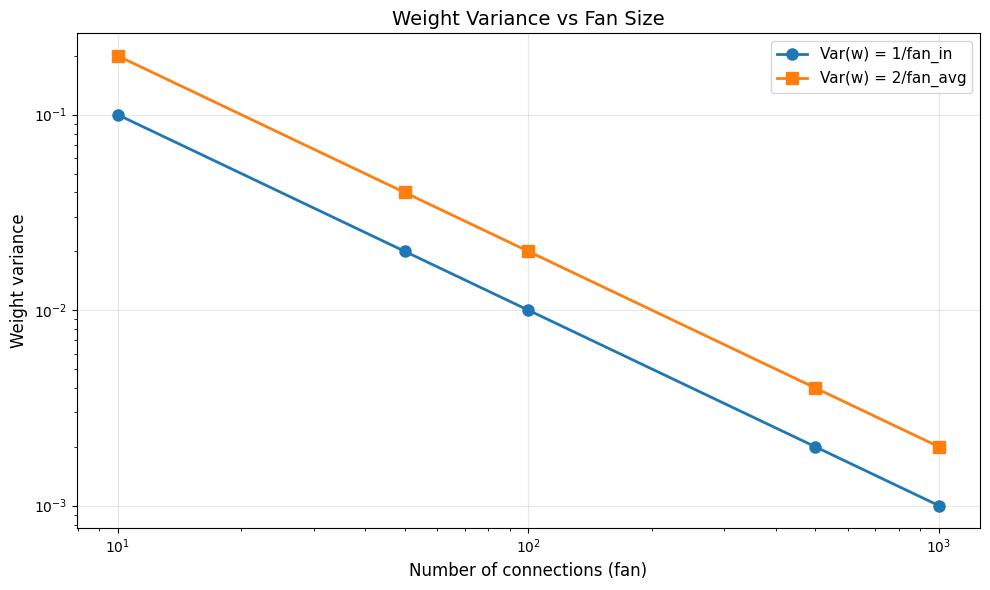


📊 Key insight: Variance decreases as fan increases to maintain signal scale


In [28]:
# Visualize fan computation for different layer types
import pandas as pd

examples = [
    ('Dense 100→50', (50, 100), 100, 50, 75),
    ('Dense 50→100', (100, 50), 50, 100, 75),
    ('Conv2D 3×3, 16→32', (32, 16, 3, 3), 16*3*3, 32*3*3, (16*3*3 + 32*3*3)/2),
    ('Conv2D 5×5, 64→128', (128, 64, 5, 5), 64*5*5, 128*5*5, (64*5*5 + 128*5*5)/2),
]

df = pd.DataFrame(examples, columns=['Layer Type', 'Shape', 'Fan-in', 'Fan-out', 'Fan-avg'])
print("\nFan Computation Examples:")
print("=" * 80)
print(df.to_string(index=False))
print("=" * 80)

# Visualize how fan affects initialization variance
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fans = [10, 50, 100, 500, 1000]
var_fan_in = [1.0 / f for f in fans]
var_fan_out = [1.0 / f for f in fans]
var_fan_avg = [2.0 / f for f in fans]  # Xavier uses 2/fan_avg

ax.loglog(fans, var_fan_in, 'o-', label='Var(w) = 1/fan_in', linewidth=2, markersize=8)
ax.loglog(fans, var_fan_avg, 's-', label='Var(w) = 2/fan_avg', linewidth=2, markersize=8)
ax.set_xlabel('Number of connections (fan)', fontsize=12)
ax.set_ylabel('Weight variance', fontsize=12)
ax.set_title('Weight Variance vs Fan Size', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key insight: Variance decreases as fan increases to maintain signal scale")

## 3. Kaiming/He Initialization (for ReLU)

### Motivation

**Kaiming/He initialization** (2015) was designed specifically for networks with **ReLU** activations. ReLU zeros out half the activations, which affects variance.

### Mathematical Derivation

For ReLU: $f(x) = \max(0, x)$

After ReLU, variance is halved (roughly), so we need:

$$\text{Var}(w) = \frac{2}{n_{in}}$$

This gives:
- **KaimingNormal**: $w \sim \mathcal{N}(0, \sqrt{2/n_{in}})$
- **KaimingUniform**: $w \sim \mathcal{U}(-\sqrt{6/n_{in}}, \sqrt{6/n_{in}})$

### When to use:
✅ ReLU or Leaky ReLU activations  
✅ Deep feedforward networks  
✅ Convolutional networks with ReLU  

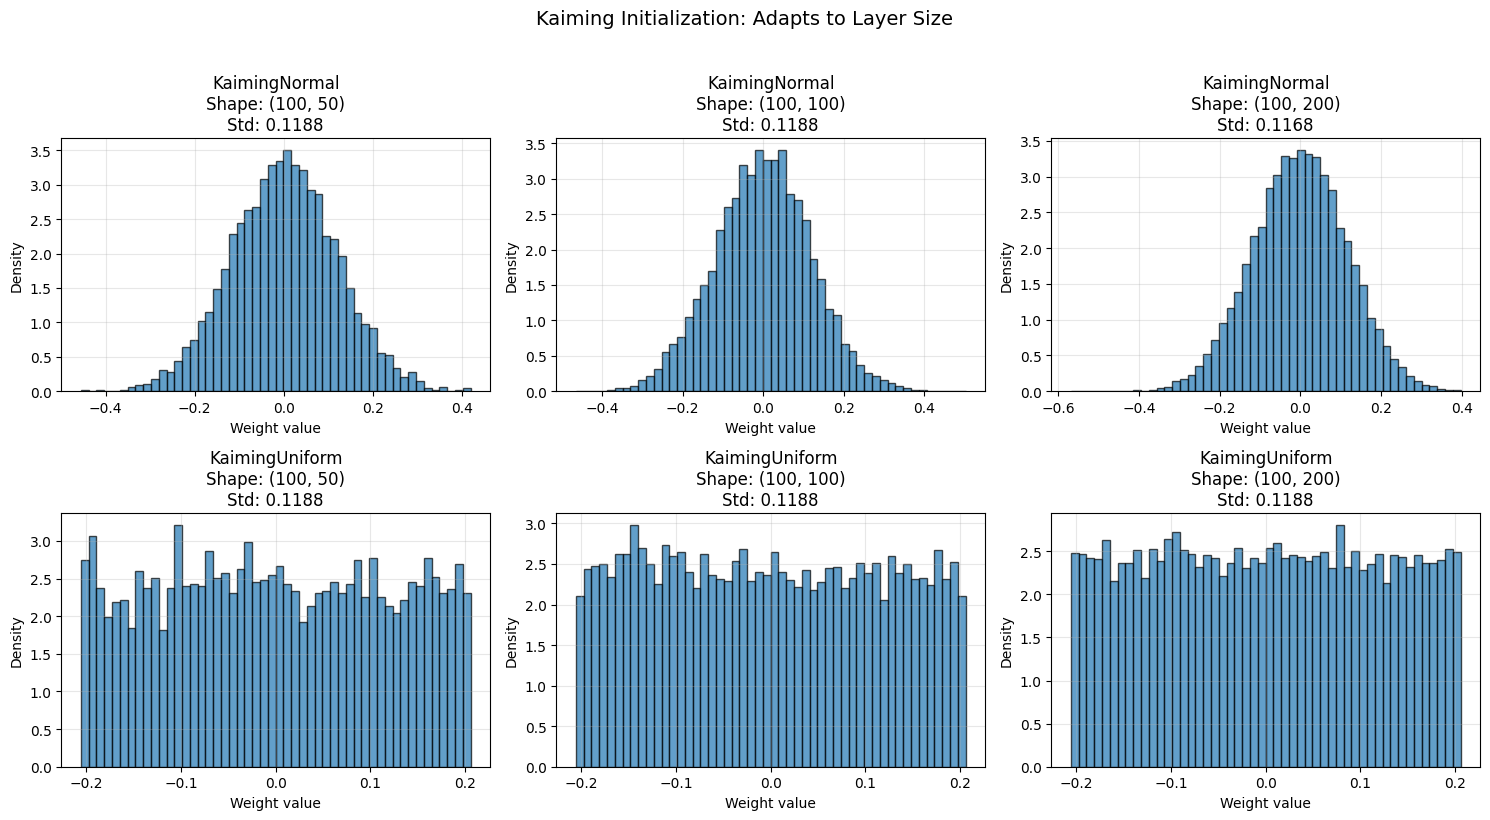


📐 Notice how the distribution narrows as fan-in increases!
This maintains consistent signal variance across layers.


In [29]:
# Create Kaiming initializers
kaiming_normal = init.KaimingNormal(mode='fan_in')
kaiming_uniform = init.KaimingUniform(mode='fan_in')

# Test with different layer sizes
layer_shapes = [(100, 50), (100, 100), (100, 200)]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, shape in enumerate(layer_shapes):
    # Generate weights
    weights_normal = kaiming_normal(shape)
    weights_uniform = kaiming_uniform(shape)
    
    # Plot Normal
    axes[0, idx].hist(weights_normal.flatten(), bins=50, alpha=0.7,
                      edgecolor='black', density=True)
    axes[0, idx].set_title(f'KaimingNormal\nShape: {shape}\nStd: {weights_normal.std():.4f}')
    axes[0, idx].set_xlabel('Weight value')
    axes[0, idx].set_ylabel('Density')
    axes[0, idx].grid(alpha=0.3)
    
    # Plot Uniform
    axes[1, idx].hist(weights_uniform.flatten(), bins=50, alpha=0.7,
                      edgecolor='black', density=True)
    axes[1, idx].set_title(f'KaimingUniform\nShape: {shape}\nStd: {weights_uniform.std():.4f}')
    axes[1, idx].set_xlabel('Weight value')
    axes[1, idx].set_ylabel('Density')
    axes[1, idx].grid(alpha=0.3)

plt.suptitle('Kaiming Initialization: Adapts to Layer Size', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📐 Notice how the distribution narrows as fan-in increases!")
print("This maintains consistent signal variance across layers.")

### Kaiming with ReLU: Signal Propagation Test

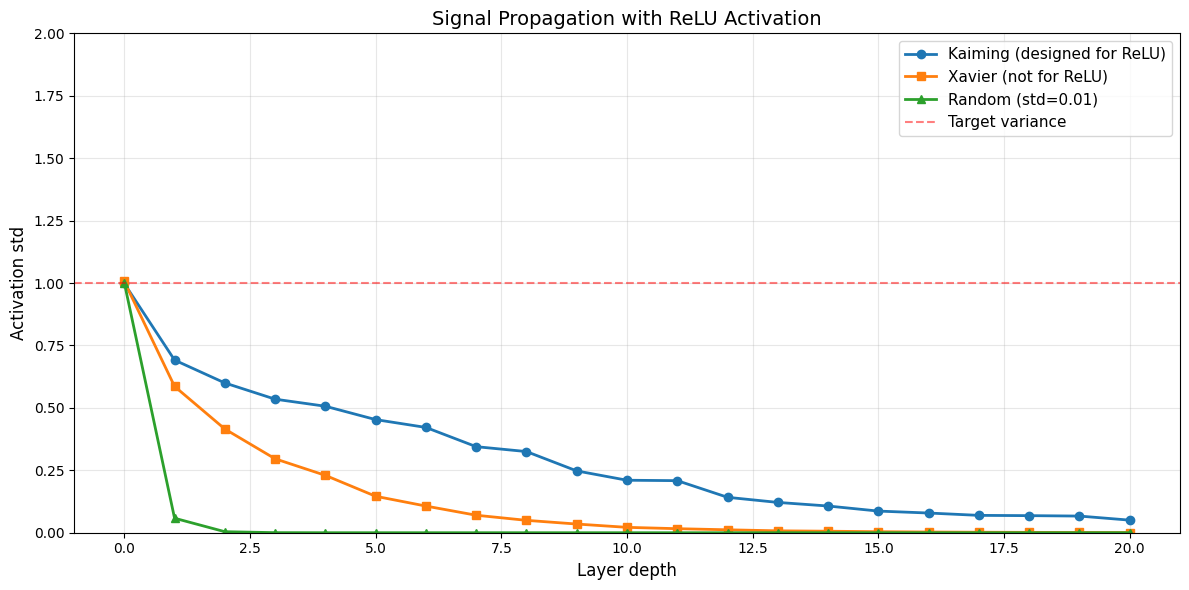


✅ Kaiming with ReLU:
  Initial std: 0.998
  Final std: 0.050
  Variance maintained: ✗

❌ Xavier with ReLU:
  Initial std: 1.006
  Final std: 0.001
  Variance maintained: ✗


In [30]:
def test_initialization_with_relu(init_method, n_layers=20, n_units=100, n_samples=1000):
    """
    Test how well an initialization method maintains signal variance with ReLU.
    """
    x = np.random.randn(n_samples, n_units)
    activations = [x]
    
    for _ in range(n_layers):
        W = init_method((n_units, n_units))
        x = x @ W
        x = np.maximum(0, x)  # ReLU
        activations.append(x)
    
    return [a.std() for a in activations]

# Compare different initializations with ReLU
kaiming_stds = test_initialization_with_relu(init.KaimingNormal())
xavier_stds = test_initialization_with_relu(init.XavierNormal())
random_stds = test_initialization_with_relu(lambda shape: np.random.randn(*shape) * 0.01)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

layers = np.arange(len(kaiming_stds))
ax.plot(layers, kaiming_stds, 'o-', label='Kaiming (designed for ReLU)', linewidth=2, markersize=6)
ax.plot(layers, xavier_stds, 's-', label='Xavier (not for ReLU)', linewidth=2, markersize=6)
ax.plot(layers, random_stds, '^-', label='Random (std=0.01)', linewidth=2, markersize=6)
ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Target variance')
ax.set_xlabel('Layer depth', fontsize=12)
ax.set_ylabel('Activation std', fontsize=12)
ax.set_title('Signal Propagation with ReLU Activation', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim([0, 2])

plt.tight_layout()
plt.show()

print(f"\n✅ Kaiming with ReLU:")
print(f"  Initial std: {kaiming_stds[0]:.3f}")
print(f"  Final std: {kaiming_stds[-1]:.3f}")
print(f"  Variance maintained: {'✓' if 0.5 < kaiming_stds[-1] < 1.5 else '✗'}")

print(f"\n❌ Xavier with ReLU:")
print(f"  Initial std: {xavier_stds[0]:.3f}")
print(f"  Final std: {xavier_stds[-1]:.3f}")
print(f"  Variance maintained: {'✓' if 0.5 < xavier_stds[-1] < 1.5 else '✗'}")

### Leaky ReLU Support

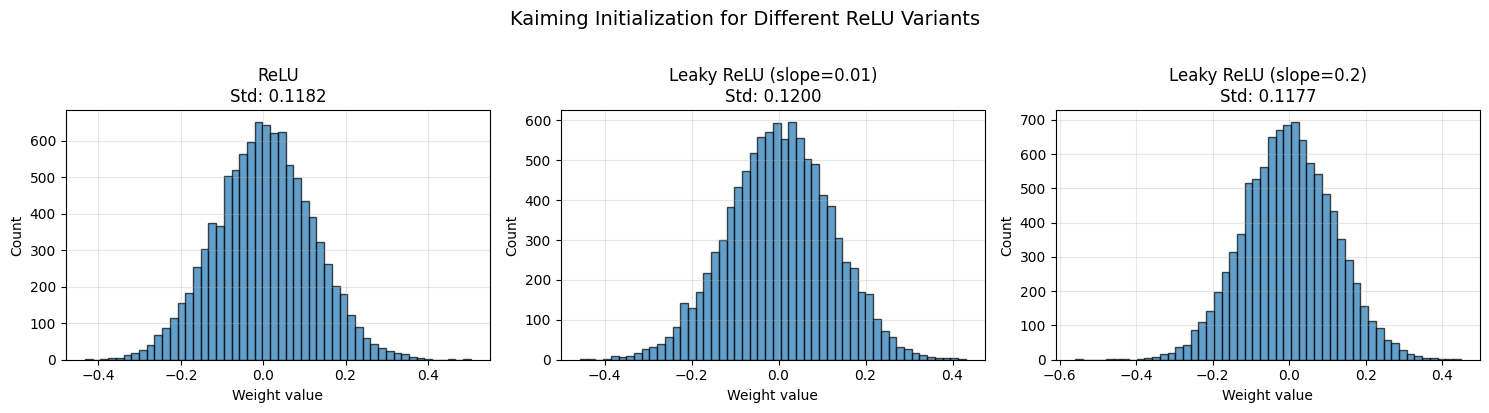


📊 Observation: Larger negative slope → smaller initialization variance
This is because less signal is killed, so we need less compensation.


In [31]:
# Kaiming initialization supports Leaky ReLU with custom negative slope
kaiming_relu = init.KaimingNormal(nonlinearity='relu')
kaiming_leaky = init.KaimingNormal(nonlinearity='leaky_relu', negative_slope=0.01)
kaiming_leaky_02 = init.KaimingNormal(nonlinearity='leaky_relu', negative_slope=0.2)

# Generate weights
shape = (100, 100)
weights_relu = kaiming_relu(shape)
weights_leaky = kaiming_leaky(shape)
weights_leaky_02 = kaiming_leaky_02(shape)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(weights_relu.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title(f'ReLU\nStd: {weights_relu.std():.4f}')
axes[0].set_xlabel('Weight value')
axes[0].set_ylabel('Count')
axes[0].grid(alpha=0.3)

axes[1].hist(weights_leaky.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title(f'Leaky ReLU (slope=0.01)\nStd: {weights_leaky.std():.4f}')
axes[1].set_xlabel('Weight value')
axes[1].set_ylabel('Count')
axes[1].grid(alpha=0.3)

axes[2].hist(weights_leaky_02.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[2].set_title(f'Leaky ReLU (slope=0.2)\nStd: {weights_leaky_02.std():.4f}')
axes[2].set_xlabel('Weight value')
axes[2].set_ylabel('Count')
axes[2].grid(alpha=0.3)

plt.suptitle('Kaiming Initialization for Different ReLU Variants', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Observation: Larger negative slope → smaller initialization variance")
print("This is because less signal is killed, so we need less compensation.")

## 4. Xavier/Glorot Initialization (for Tanh/Sigmoid)

### Motivation

**Xavier/Glorot initialization** (2010) was designed for **symmetric** activation functions like tanh and sigmoid. It balances forward and backward signal flow.

### Mathematical Derivation

Xavier aims to maintain variance in both directions:
- Forward: $\text{Var}(w) = 1/n_{in}$
- Backward: $\text{Var}(w) = 1/n_{out}$

Compromise using **fan_avg**:

$$\text{Var}(w) = \frac{2}{n_{in} + n_{out}}$$

This gives:
- **XavierNormal**: $w \sim \mathcal{N}(0, \sqrt{2/(n_{in} + n_{out})})$
- **XavierUniform**: $w \sim \mathcal{U}(-\sqrt{6/(n_{in} + n_{out})}, \sqrt{6/(n_{in} + n_{out})})$

### When to use:
✅ Tanh or sigmoid activations  
✅ Networks with symmetric activations  
✅ Balanced forward/backward propagation  
❌ **Not** for ReLU (use Kaiming instead)

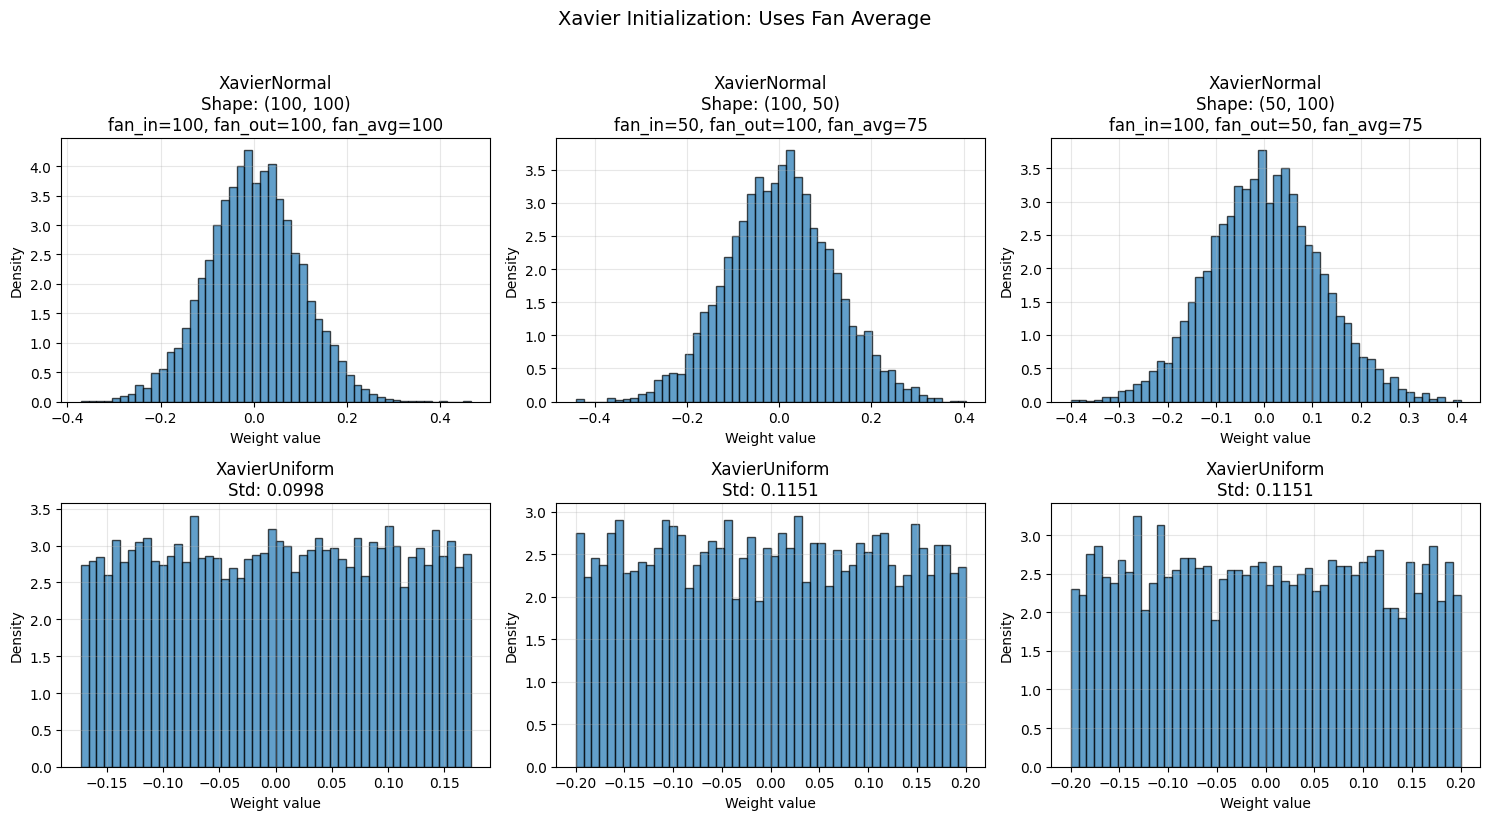

In [32]:
# Create Xavier initializers
xavier_normal = init.XavierNormal()
xavier_uniform = init.XavierUniform()

# Test with different layer sizes
shapes = [(100, 100), (100, 50), (50, 100)]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, shape in enumerate(shapes):
    weights_normal = xavier_normal(shape)
    weights_uniform = xavier_uniform(shape)
    
    # Compute fan values
    fan_in, fan_out = shape[1], shape[0]
    fan_avg = (fan_in + fan_out) / 2
    
    # Plot Normal
    axes[0, idx].hist(weights_normal.flatten(), bins=50, alpha=0.7,
                      edgecolor='black', density=True)
    axes[0, idx].set_title(f'XavierNormal\nShape: {shape}\n'
                           f'fan_in={fan_in}, fan_out={fan_out}, fan_avg={fan_avg:.0f}')
    axes[0, idx].set_xlabel('Weight value')
    axes[0, idx].set_ylabel('Density')
    axes[0, idx].grid(alpha=0.3)
    
    # Plot Uniform
    axes[1, idx].hist(weights_uniform.flatten(), bins=50, alpha=0.7,
                      edgecolor='black', density=True)
    axes[1, idx].set_title(f'XavierUniform\nStd: {weights_uniform.std():.4f}')
    axes[1, idx].set_xlabel('Weight value')
    axes[1, idx].set_ylabel('Density')
    axes[1, idx].grid(alpha=0.3)

plt.suptitle('Xavier Initialization: Uses Fan Average', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Xavier with Tanh: Signal Propagation Test

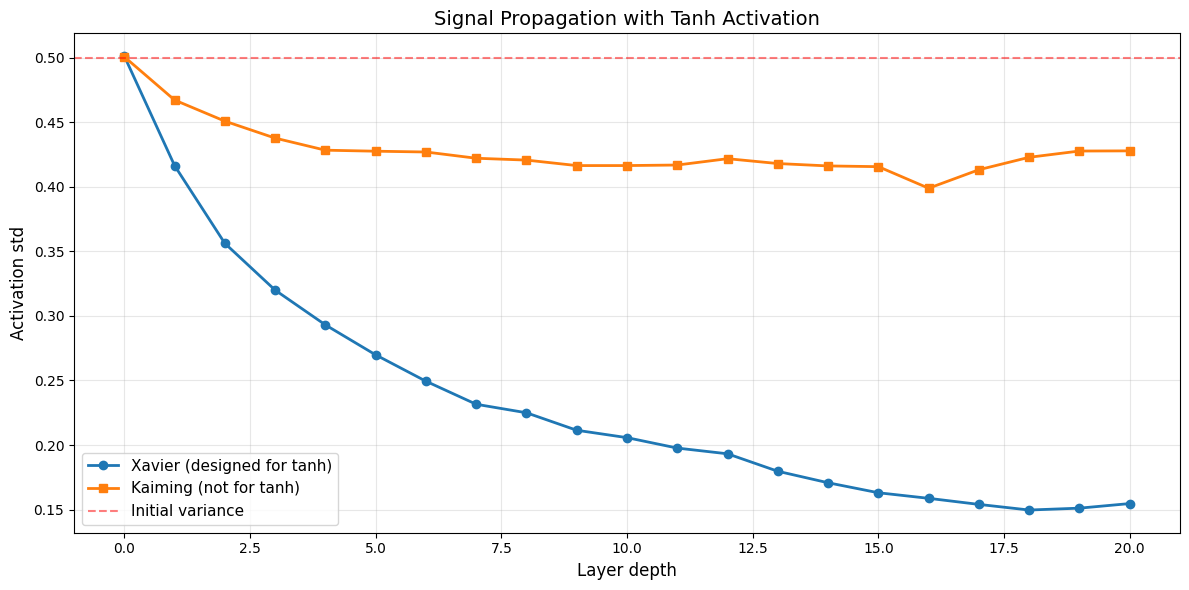


✅ Xavier with Tanh:
  Initial std: 0.501
  Final std: 0.155
  Signal maintained: ✓

⚠️ Kaiming with Tanh:
  Initial std: 0.501
  Final std: 0.428
  Signal maintained: ✓


In [33]:
def test_initialization_with_tanh(init_method, n_layers=20, n_units=100, n_samples=1000):
    """
    Test how well an initialization method maintains signal variance with tanh.
    """
    x = np.random.randn(n_samples, n_units) * 0.5  # Small initial variance
    activations = [x]
    
    for _ in range(n_layers):
        W = init_method((n_units, n_units))
        x = x @ W
        x = np.tanh(x)  # Tanh activation
        activations.append(x)
    
    return [a.std() for a in activations]

# Compare different initializations with tanh
xavier_stds_tanh = test_initialization_with_tanh(init.XavierNormal())
kaiming_stds_tanh = test_initialization_with_tanh(init.KaimingNormal())

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

layers = np.arange(len(xavier_stds_tanh))
ax.plot(layers, xavier_stds_tanh, 'o-', label='Xavier (designed for tanh)', 
        linewidth=2, markersize=6)
ax.plot(layers, kaiming_stds_tanh, 's-', label='Kaiming (not for tanh)', 
        linewidth=2, markersize=6)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Initial variance')
ax.set_xlabel('Layer depth', fontsize=12)
ax.set_ylabel('Activation std', fontsize=12)
ax.set_title('Signal Propagation with Tanh Activation', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Xavier with Tanh:")
print(f"  Initial std: {xavier_stds_tanh[0]:.3f}")
print(f"  Final std: {xavier_stds_tanh[-1]:.3f}")
print(f"  Signal maintained: {'✓' if xavier_stds_tanh[-1] > 0.1 else '✗'}")

print(f"\n⚠️ Kaiming with Tanh:")
print(f"  Initial std: {kaiming_stds_tanh[0]:.3f}")
print(f"  Final std: {kaiming_stds_tanh[-1]:.3f}")
print(f"  Signal maintained: {'✓' if kaiming_stds_tanh[-1] > 0.1 else '✗'}")

## 5. LeCun Initialization (for SELU)

### Motivation

**LeCun initialization** (1998) is the original variance scaling method. It's specifically suited for **SELU** (Self-Normalizing) activations, which have self-normalizing properties.

### Mathematical Foundation

LeCun uses **fan_in** only:

$$\text{Var}(w) = \frac{1}{n_{in}}$$

This gives:
- **LecunNormal**: $w \sim \mathcal{N}(0, \sqrt{1/n_{in}})$
- **LecunUniform**: $w \sim \mathcal{U}(-\sqrt{3/n_{in}}, \sqrt{3/n_{in}})$

### When to use:
✅ SELU activations  
✅ Self-normalizing networks  
✅ When you want to focus on forward pass  

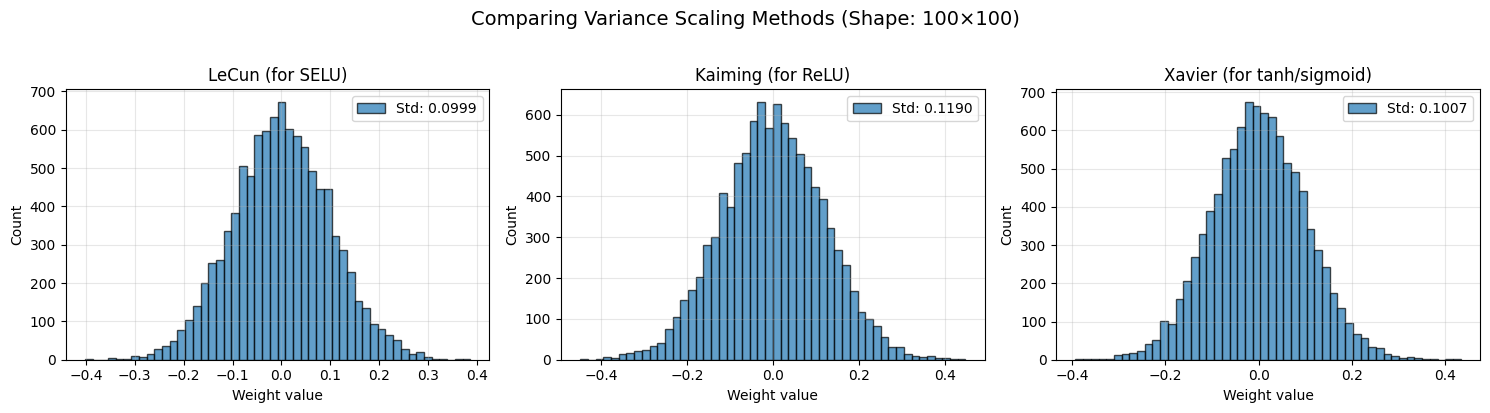


📊 Standard deviation comparison:
  LeCun:   0.0999 (scale = √(1/fan_in))
  Kaiming: 0.1190 (scale = √(2/fan_in))
  Xavier:  0.1007 (scale = √(2/fan_avg))

Kaiming ≈ √2 × LeCun (accounts for ReLU killing half the signal)


In [34]:
# Create LeCun initializers
lecun_normal = init.LecunNormal()
lecun_uniform = init.LecunUniform()

# Compare LeCun with Kaiming and Xavier
shape = (100, 100)
weights_lecun = lecun_normal(shape)
weights_kaiming = init.KaimingNormal()(shape)
weights_xavier = init.XavierNormal()(shape)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(weights_lecun.flatten(), bins=50, alpha=0.7,
             edgecolor='black', label=f'Std: {weights_lecun.std():.4f}')
axes[0].set_title('LeCun (for SELU)')
axes[0].set_xlabel('Weight value')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(weights_kaiming.flatten(), bins=50, alpha=0.7,
             edgecolor='black', label=f'Std: {weights_kaiming.std():.4f}')
axes[1].set_title('Kaiming (for ReLU)')
axes[1].set_xlabel('Weight value')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].hist(weights_xavier.flatten(), bins=50, alpha=0.7,
             edgecolor='black', label=f'Std: {weights_xavier.std():.4f}')
axes[2].set_title('Xavier (for tanh/sigmoid)')
axes[2].set_xlabel('Weight value')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('Comparing Variance Scaling Methods (Shape: 100×100)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Standard deviation comparison:")
print(f"  LeCun:   {weights_lecun.std():.4f} (scale = √(1/fan_in))")
print(f"  Kaiming: {weights_kaiming.std():.4f} (scale = √(2/fan_in))")
print(f"  Xavier:  {weights_xavier.std():.4f} (scale = √(2/fan_avg))")
print("\nKaiming ≈ √2 × LeCun (accounts for ReLU killing half the signal)")

### Comparison of All Variance Scaling Methods

In [35]:
# Summary table
import pandas as pd

shape = (100, 100)
methods = {
    'LeCun': init.LecunNormal(),
    'Kaiming': init.KaimingNormal(),
    'Xavier': init.XavierNormal(),
}

results = []
for name, method in methods.items():
    weights = method(shape)
    results.append({
        'Method': name,
        'Std': f"{weights.std():.4f}",
        'Variance': f"{(weights.std()**2):.6f}",
        'Fan Mode': method.mode if hasattr(method, 'mode') else 'fan_in',
        'Best For': {
            'LeCun': 'SELU',
            'Kaiming': 'ReLU/Leaky ReLU',
            'Xavier': 'Tanh/Sigmoid'
        }[name]
    })

df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("VARIANCE SCALING METHODS COMPARISON (Shape: 100×100)")
print("=" * 80)
print(df.to_string(index=False))
print("=" * 80)


VARIANCE SCALING METHODS COMPARISON (Shape: 100×100)
 Method    Std Variance Fan Mode        Best For
  LeCun 0.0993 0.009869   fan_in            SELU
Kaiming 0.1187 0.014085   fan_in ReLU/Leaky ReLU
 Xavier 0.0997 0.009940  fan_avg    Tanh/Sigmoid


## 6. Orthogonal Initialization

### Motivation

**Orthogonal initialization** creates weight matrices where rows (or columns) are orthogonal to each other. This has special properties:

- **Preserves norms**: $||Wx|| = ||x||$ for orthogonal $W$
- **Prevents gradient explosion/vanishing** in RNNs
- **Dynamic isometry** in deep networks

### Mathematical Properties

For orthogonal matrix $Q$:
- $Q^T Q = I$ (identity)
- All singular values equal 1
- Preserves angles and lengths

### When to use:
✅ **Recurrent Neural Networks (RNNs)** - prevents gradient problems  
✅ **Very deep networks** - maintains gradient flow  
✅ **When norm preservation is important**  

Orthogonality verification:
  Max error from identity: 5.96e-07
  Is orthogonal: ✓


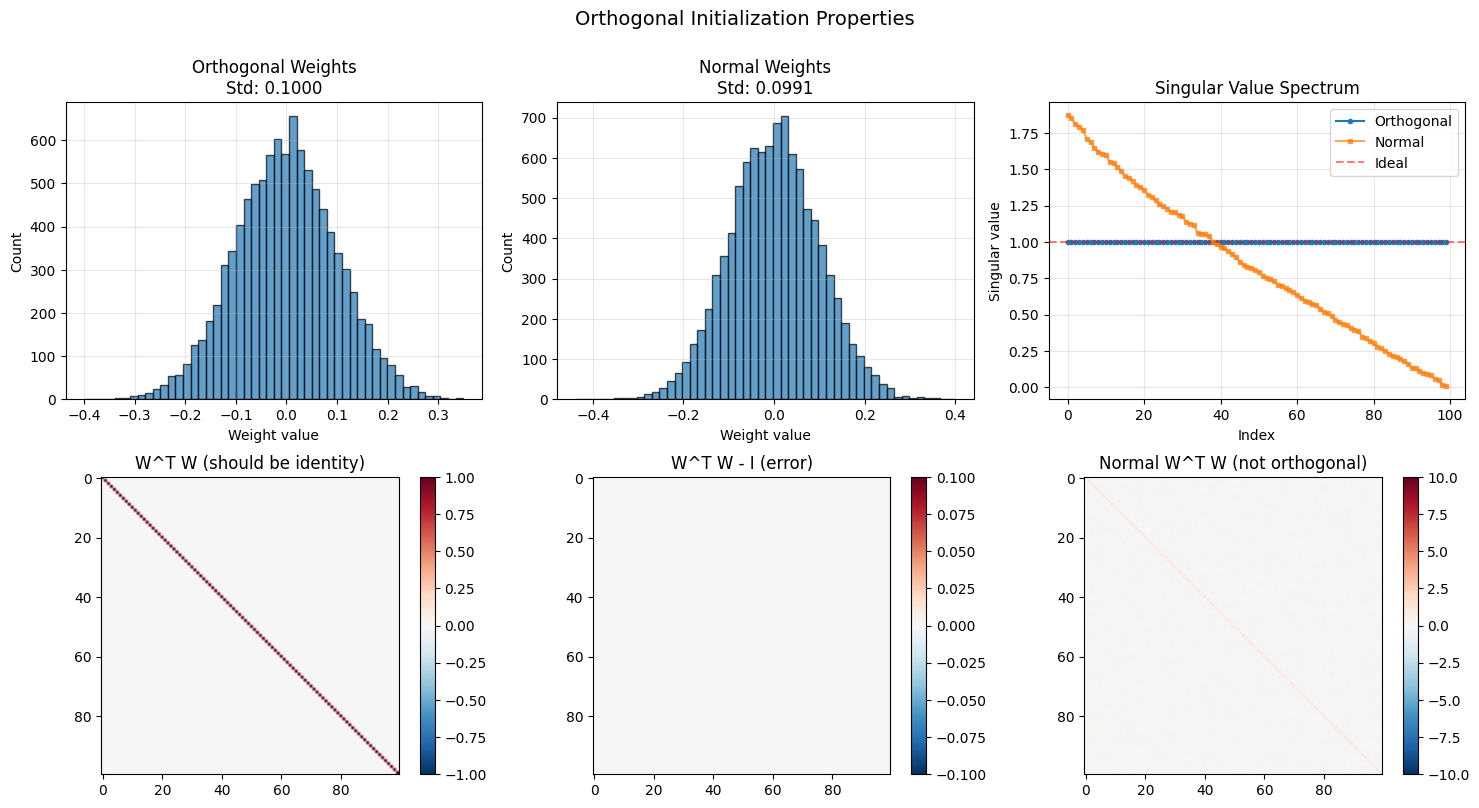


📊 Key observations:
  1. All singular values of orthogonal matrix are 1.0
  2. W^T W = I (rows are orthonormal)
  3. Normal initialization lacks these properties


In [36]:
# Create orthogonal initializer
orthogonal_init = init.Orthogonal(scale=1.0)

# Generate orthogonal weights
shape = (100, 100)
weights_ortho = orthogonal_init(shape)
weights_normal = init.Normal(0.0, 0.1)(shape)

# Verify orthogonality
W = weights_ortho
product = W.T @ W
identity = np.eye(shape[0])
orthogonality_error = np.abs(product - identity).max()

print(f"Orthogonality verification:")
print(f"  Max error from identity: {orthogonality_error:.2e}")
print(f"  Is orthogonal: {'✓' if orthogonality_error < 1e-6 else '✗'}")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Weight distributions
axes[0, 0].hist(weights_ortho.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title(f'Orthogonal Weights\nStd: {weights_ortho.std():.4f}')
axes[0, 0].set_xlabel('Weight value')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(weights_normal.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title(f'Normal Weights\nStd: {weights_normal.std():.4f}')
axes[0, 1].set_xlabel('Weight value')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(alpha=0.3)

# Singular values
U, s_ortho, Vt = np.linalg.svd(weights_ortho)
U, s_normal, Vt = np.linalg.svd(weights_normal)

axes[0, 2].plot(s_ortho, 'o-', label='Orthogonal', markersize=3)
axes[0, 2].plot(s_normal, 's-', label='Normal', markersize=3, alpha=0.7)
axes[0, 2].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')
axes[0, 2].set_xlabel('Index')
axes[0, 2].set_ylabel('Singular value')
axes[0, 2].set_title('Singular Value Spectrum')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# W^T W visualization
im1 = axes[1, 0].imshow(product, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('W^T W (should be identity)')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(product - identity, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
axes[1, 1].set_title('W^T W - I (error)')
plt.colorbar(im2, ax=axes[1, 1])

# Correlation between rows
W_normal = weights_normal
product_normal = W_normal.T @ W_normal
im3 = axes[1, 2].imshow(product_normal, cmap='RdBu_r', vmin=-10, vmax=10)
axes[1, 2].set_title('Normal W^T W (not orthogonal)')
plt.colorbar(im3, ax=axes[1, 2])

plt.suptitle('Orthogonal Initialization Properties', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print(f"\n📊 Key observations:")
print(f"  1. All singular values of orthogonal matrix are 1.0")
print(f"  2. W^T W = I (rows are orthonormal)")
print(f"  3. Normal initialization lacks these properties")

### Orthogonal for RNNs: Gradient Flow Test

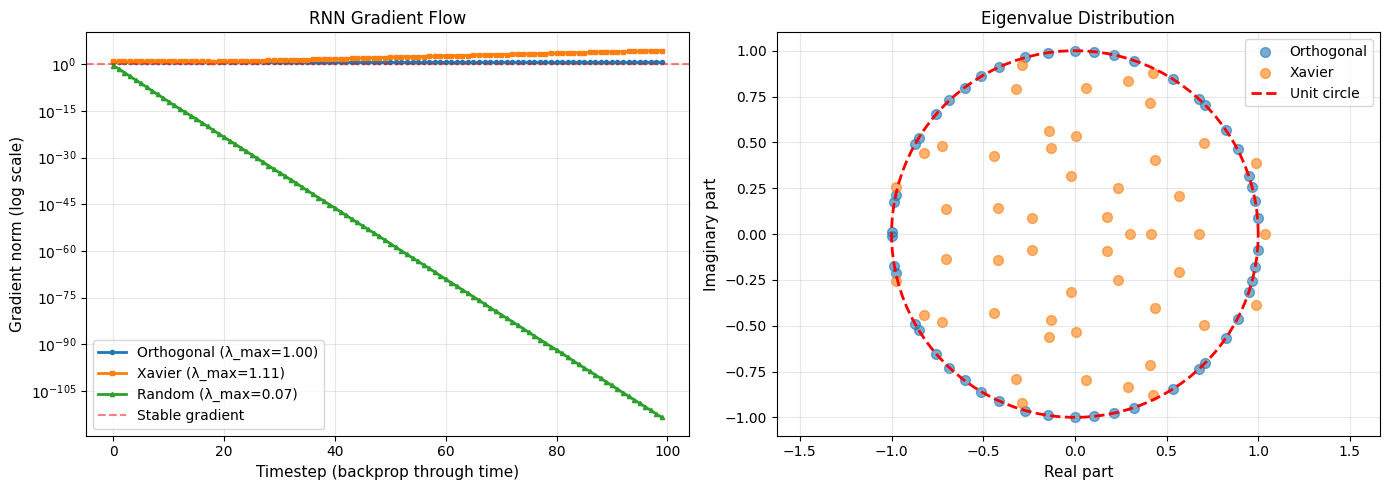


✅ Orthogonal initialization for RNNs:
  - Maintains gradient magnitude over time
  - All eigenvalues on unit circle (|λ| = 1)
  - Prevents vanishing/exploding gradients

❌ Other methods:
  - Gradients decay (Xavier) or explode
  - Eigenvalues not on unit circle


In [37]:
def test_rnn_gradient_flow(init_method, n_timesteps=100, hidden_size=50):
    """
    Simulate gradient flow in an RNN to test initialization.
    """
    W = init_method((hidden_size, hidden_size))

    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(W)
    max_eigenvalue = np.abs(eigenvalues).max()
    
    # Simulate gradient magnitude over time
    gradient_norms = []
    grad = np.random.randn(hidden_size)
    
    for t in range(n_timesteps):
        grad = W.T @ grad
        gradient_norms.append(np.linalg.norm(grad))
    
    return gradient_norms, max_eigenvalue

# Test different initializations
ortho_grads, ortho_eig = test_rnn_gradient_flow(init.Orthogonal())
xavier_grads, xavier_eig = test_rnn_gradient_flow(init.XavierNormal())
random_grads, random_eig = test_rnn_gradient_flow(lambda shape: np.random.randn(*shape) * 0.01)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gradient norms over time
timesteps = np.arange(len(ortho_grads))
axes[0].semilogy(timesteps, ortho_grads, 'o-', label=f'Orthogonal (λ_max={ortho_eig:.2f})', 
                 linewidth=2, markersize=3)
axes[0].semilogy(timesteps, xavier_grads, 's-', label=f'Xavier (λ_max={xavier_eig:.2f})', 
                 linewidth=2, markersize=3)
axes[0].semilogy(timesteps, random_grads, '^-', label=f'Random (λ_max={random_eig:.2f})', 
                 linewidth=2, markersize=3)
axes[0].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Stable gradient')
axes[0].set_xlabel('Timestep (backprop through time)', fontsize=11)
axes[0].set_ylabel('Gradient norm (log scale)', fontsize=11)
axes[0].set_title('RNN Gradient Flow', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Eigenvalue distribution
W_ortho = init.Orthogonal()((50, 50))
W_xavier = init.XavierNormal()((50, 50))

eig_ortho = np.linalg.eigvals(W_ortho)
eig_xavier = np.linalg.eigvals(W_xavier)

axes[1].scatter(eig_ortho.real, eig_ortho.imag, alpha=0.6, s=50, label='Orthogonal')
axes[1].scatter(eig_xavier.real, eig_xavier.imag, alpha=0.6, s=50, label='Xavier')

# Draw unit circle
theta = np.linspace(0, 2*np.pi, 100)
axes[1].plot(np.cos(theta), np.sin(theta), 'r--', linewidth=2, label='Unit circle')
axes[1].set_xlabel('Real part', fontsize=11)
axes[1].set_ylabel('Imaginary part', fontsize=11)
axes[1].set_title('Eigenvalue Distribution', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

print("\n✅ Orthogonal initialization for RNNs:")
print(f"  - Maintains gradient magnitude over time")
print(f"  - All eigenvalues on unit circle (|λ| = 1)")
print(f"  - Prevents vanishing/exploding gradients")
print(f"\n❌ Other methods:")
print(f"  - Gradients decay (Xavier) or explode")
print(f"  - Eigenvalues not on unit circle")

### Scaled Orthogonal Initialization

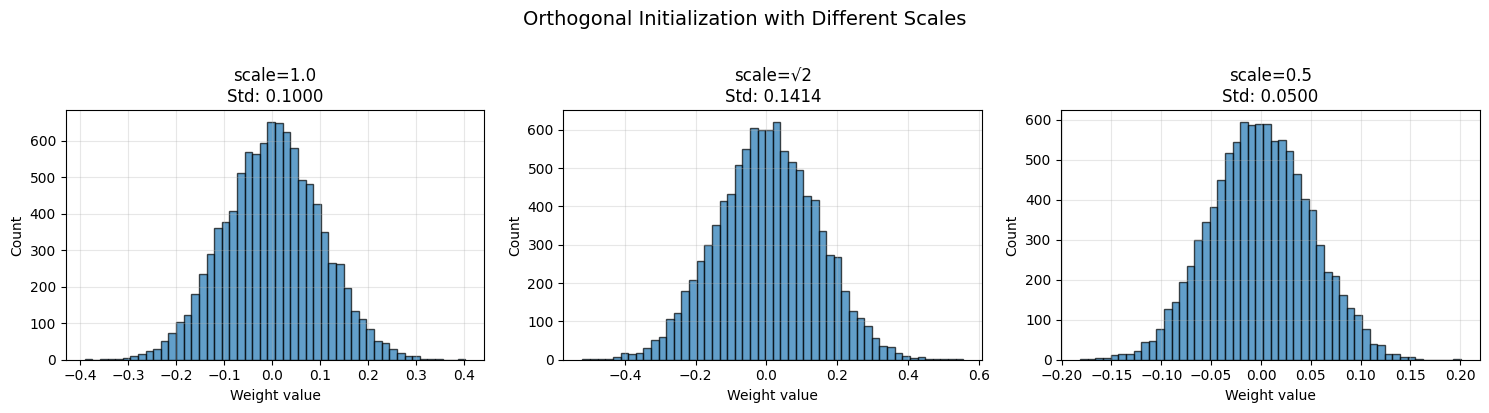


📊 Scale effects:
  scale=1.0:  std=0.1000 (preserves norms exactly)
  scale=√2:   std=0.1414 (common for ReLU in RNNs)
  scale=0.5:  std=0.0500 (dampens signals)


In [38]:
# Orthogonal with different scales
ortho_1 = init.Orthogonal(scale=1.0)
ortho_sqrt2 = init.Orthogonal(scale=np.sqrt(2))  # Common for RNNs
ortho_05 = init.Orthogonal(scale=0.5)

shape = (100, 100)
weights_1 = ortho_1(shape)
weights_sqrt2 = ortho_sqrt2(shape)
weights_05 = ortho_05(shape)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, weights, scale_name in zip(axes, 
                                     [weights_1, weights_sqrt2, weights_05],
                                     ['scale=1.0', 'scale=√2', 'scale=0.5']):
    ax.hist(weights.flatten(), bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'{scale_name}\nStd: {weights.std():.4f}')
    ax.set_xlabel('Weight value')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

plt.suptitle('Orthogonal Initialization with Different Scales', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Scale effects:")
print(f"  scale=1.0:  std={weights_1.std():.4f} (preserves norms exactly)")
print(f"  scale=√2:   std={weights_sqrt2.std():.4f} (common for ReLU in RNNs)")
print(f"  scale=0.5:  std={weights_05.std():.4f} (dampens signals)")

## 7. DeltaOrthogonal (for Deep CNNs)

### Motivation

**DeltaOrthogonal** is designed for very deep convolutional networks. It combines:
- **Delta function** in spatial dimensions (all zeros except center)
- **Orthogonal** in channel dimensions

This creates identity-like convolutions that preserve information while maintaining orthogonality.

### When to use:
✅ **Very deep CNNs** (100+ layers)  
✅ **Residual-like architectures**  
✅ **When skip connections aren't possible**  

DeltaOrthogonal weights shape: (32, 32, 3, 3)


C:\Users\adadu\AppData\Local\Temp\ipykernel_27308\332873120.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


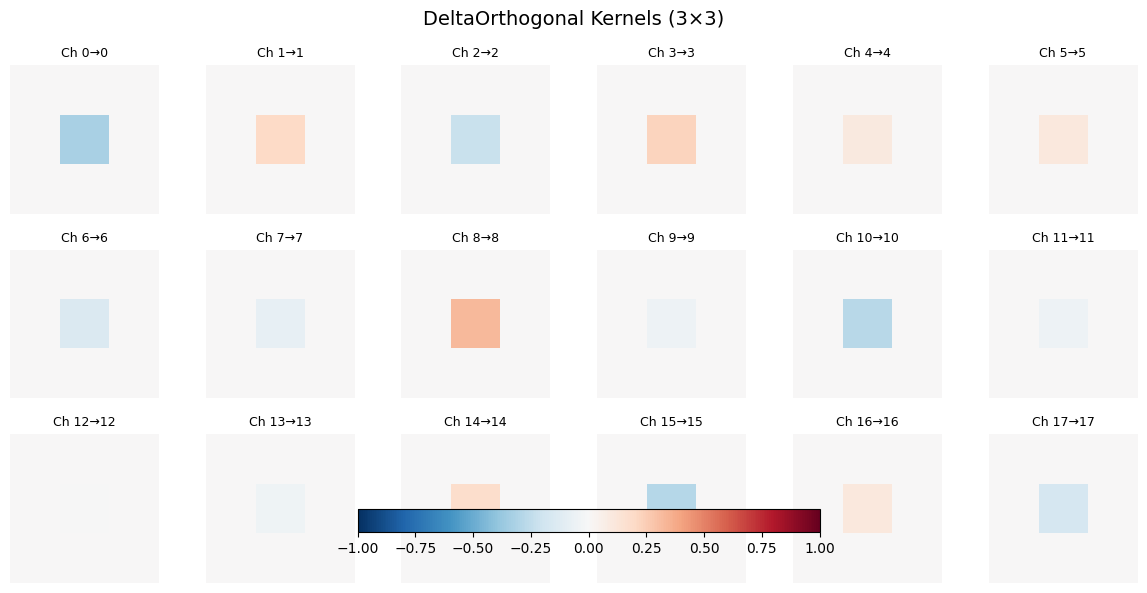

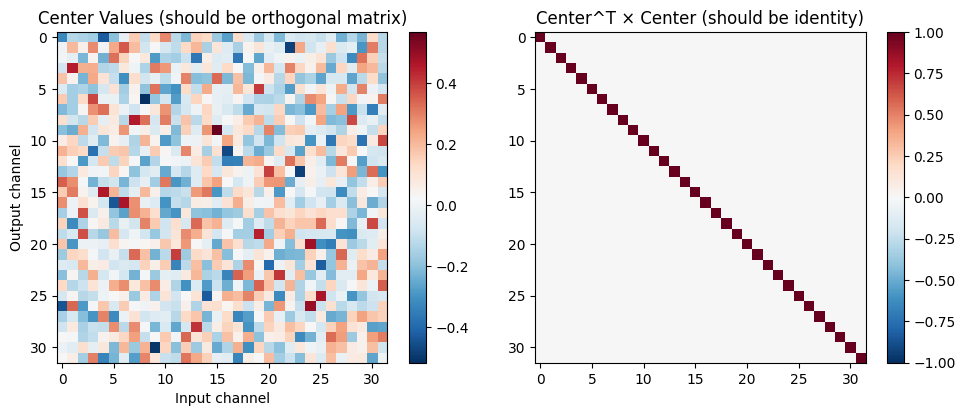


✓ DeltaOrthogonal properties:
  - Only center pixel has non-zero values
  - Center values form an orthogonal matrix
  - Acts like identity convolution with orthogonality


In [39]:
# Create DeltaOrthogonal initializer
delta_ortho = init.DeltaOrthogonal(scale=1.0)

# For a 3x3 convolutional kernel with 32 input and 32 output channels
shape = (32, 32, 3, 3)  # (out_channels, in_channels, height, width)
weights = delta_ortho(shape)

print(f"DeltaOrthogonal weights shape: {weights.shape}")

# Visualize a few kernels
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
axes = axes.flatten()

for i in range(18):
    # Show kernel for output channel i, input channel i
    if i < min(shape[0], shape[1]):
        kernel = weights[i, i, :, :]
        im = axes[i].imshow(kernel, cmap='RdBu_r', vmin=-1, vmax=1)
        axes[i].set_title(f'Ch {i}→{i}', fontsize=9)
    axes[i].axis('off')

plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.05, fraction=0.05)
plt.suptitle('DeltaOrthogonal Kernels (3×3)', fontsize=14)
plt.tight_layout()
plt.show()

# Show the center values are orthogonal
center = weights[:, :, 1, 1]  # Center of 3x3 kernels
product = center.T @ center

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im1 = axes[0].imshow(center, cmap='RdBu_r')
axes[0].set_title('Center Values (should be orthogonal matrix)')
axes[0].set_xlabel('Input channel')
axes[0].set_ylabel('Output channel')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(product, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1].set_title('Center^T × Center (should be identity)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\n✓ DeltaOrthogonal properties:")
print(f"  - Only center pixel has non-zero values")
print(f"  - Center values form an orthogonal matrix")
print(f"  - Acts like identity convolution with orthogonality")

## 8. Identity Initialization

### Motivation

**Identity initialization** sets weights to an identity matrix (or as close as possible for non-square matrices). This is particularly useful for:

- **Skip connections** / **Residual networks**
- **RNNs** (combined with small noise)
- **When you want minimal transformation initially**

### When to use:
✅ Residual connections  
✅ RNNs (with small noise added)  
✅ Fine-tuning from identity  

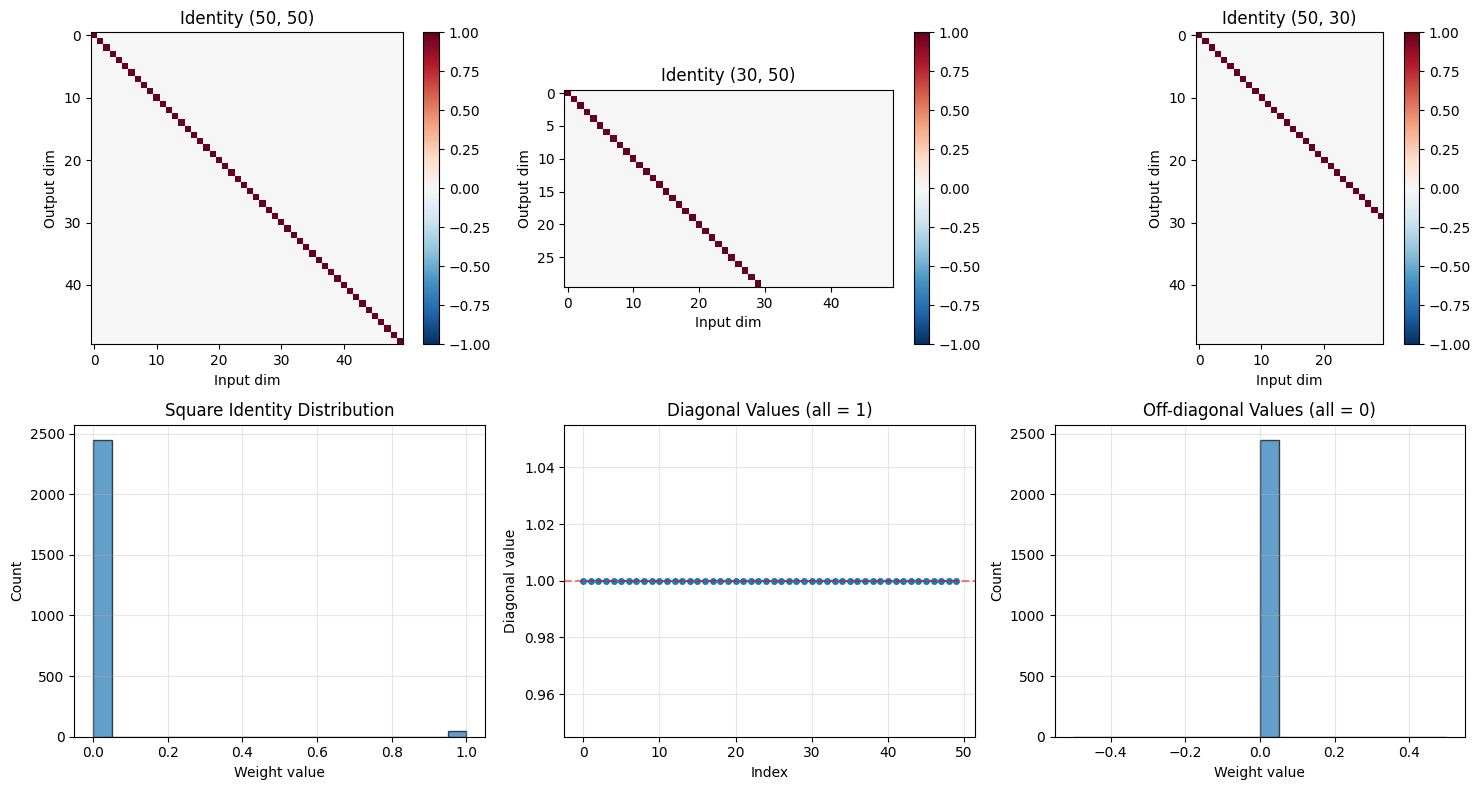


✓ Identity initialization properties:
  Square: Perfect identity matrix
  Wide: Identity in first N columns, zeros elsewhere
  Tall: Identity in first N rows, zeros elsewhere


In [40]:
# Create identity initializers
identity_1 = init.Identity(scale=1.0)
identity_small = init.Identity(scale=0.1)

# Test with square matrix
shape_square = (50, 50)
weights_identity = identity_1(shape_square)

# Test with rectangular matrices
shape_wide = (30, 50)
shape_tall = (50, 30)
weights_wide = identity_1(shape_wide)
weights_tall = identity_1(shape_tall)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Square identity
im1 = axes[0, 0].imshow(weights_identity, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0, 0].set_title(f'Identity {shape_square}')
axes[0, 0].set_xlabel('Input dim')
axes[0, 0].set_ylabel('Output dim')
plt.colorbar(im1, ax=axes[0, 0])

# Wide identity
im2 = axes[0, 1].imshow(weights_wide, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0, 1].set_title(f'Identity {shape_wide}')
axes[0, 1].set_xlabel('Input dim')
axes[0, 1].set_ylabel('Output dim')
plt.colorbar(im2, ax=axes[0, 1])

# Tall identity
im3 = axes[0, 2].imshow(weights_tall, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0, 2].set_title(f'Identity {shape_tall}')
axes[0, 2].set_xlabel('Input dim')
axes[0, 2].set_ylabel('Output dim')
plt.colorbar(im3, ax=axes[0, 2])

# Distribution comparison
axes[1, 0].hist(weights_identity.flatten(), bins=20, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Square Identity Distribution')
axes[1, 0].set_xlabel('Weight value')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(alpha=0.3)

# Diagonal values
diag_values = np.diag(weights_identity)
axes[1, 1].plot(diag_values, 'o-', markersize=4)
axes[1, 1].axhline(1.0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Diagonal value')
axes[1, 1].set_title('Diagonal Values (all = 1)')
axes[1, 1].grid(alpha=0.3)

# Off-diagonal values
mask = ~np.eye(shape_square[0], dtype=bool)
off_diag = weights_identity[mask]
axes[1, 2].hist(off_diag, bins=20, alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Weight value')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Off-diagonal Values (all = 0)')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Identity initialization properties:")
print(f"  Square: Perfect identity matrix")
print(f"  Wide: Identity in first N columns, zeros elsewhere")
print(f"  Tall: Identity in first N rows, zeros elsewhere")

### Identity + Noise for RNNs

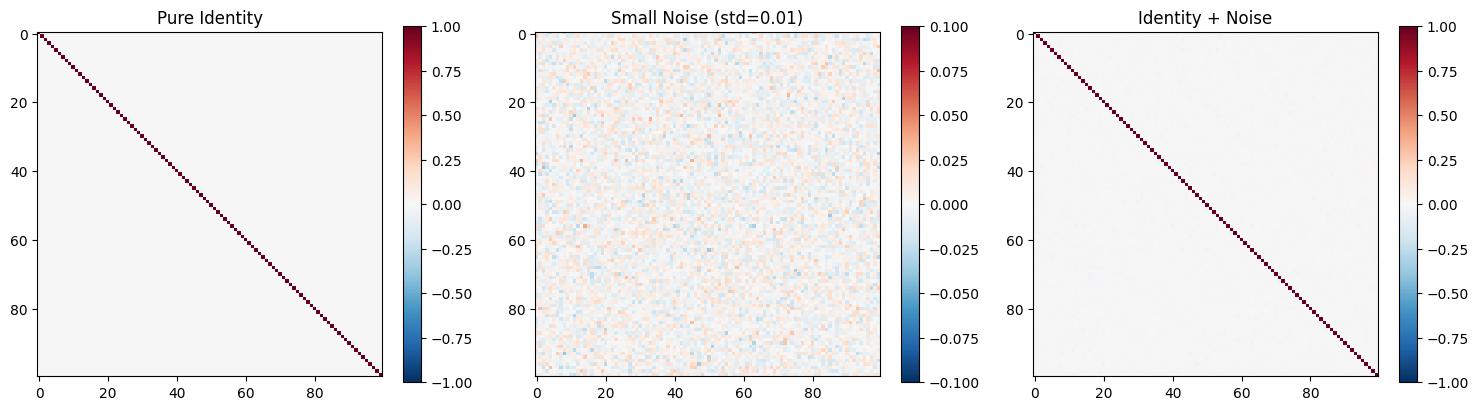


💡 Identity + Noise for RNNs:
  - Start with identity (no transformation)
  - Add small noise to break symmetry
  - Helps learning while preventing gradient problems


In [41]:
# Common pattern: Identity + small noise
shape = (100, 100)
identity_weights = init.Identity(scale=1.0)(shape)
noise = np.random.randn(*shape) * 0.01
weights_with_noise = identity_weights + noise

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(identity_weights, cmap='RdBu_r', vmin=-1, vmax=1)
axes[0].set_title('Pure Identity')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(noise, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
axes[1].set_title('Small Noise (std=0.01)')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(weights_with_noise, cmap='RdBu_r', vmin=-1, vmax=1)
axes[2].set_title('Identity + Noise')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("\n💡 Identity + Noise for RNNs:")
print("  - Start with identity (no transformation)")
print("  - Add small noise to break symmetry")
print("  - Helps learning while preventing gradient problems")

## 9. Complete Comparison and Decision Guide

### All Methods Side-by-Side

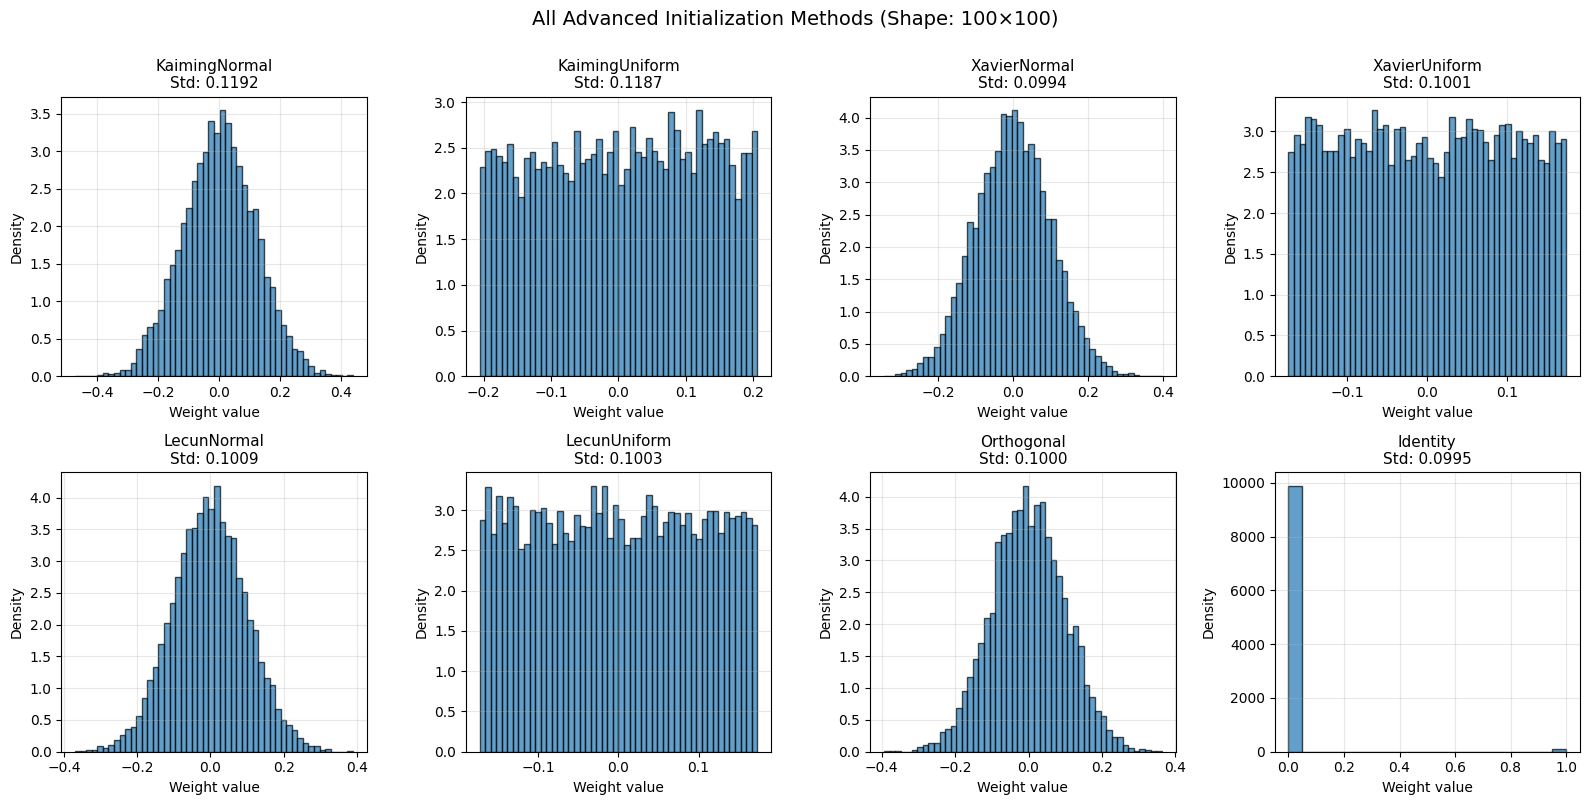


ADVANCED INITIALIZATION METHODS COMPARISON
Method               Mean         Std          Min          Max         
------------------------------------------------------------------------------------------
KaimingNormal        -0.000167    0.119221     -0.472608    0.437831    
KaimingUniform       0.002735     0.118657     -0.205950    0.205945    
XavierNormal         -0.000682    0.099363     -0.343731    0.396122    
XavierUniform        -0.000478    0.100142     -0.173172    0.173171    
LecunNormal          -0.001946    0.100878     -0.369501    0.389214    
LecunUniform         -0.000452    0.100303     -0.173174    0.173146    
Orthogonal           -0.001150    0.099993     -0.393372    0.362493    
Identity             0.010000     0.099499     0.000000     1.000000    


In [42]:
# Create all initializers
shape = (100, 100)
initializers = {
    'KaimingNormal': init.KaimingNormal(),
    'KaimingUniform': init.KaimingUniform(),
    'XavierNormal': init.XavierNormal(),
    'XavierUniform': init.XavierUniform(),
    'LecunNormal': init.LecunNormal(),
    'LecunUniform': init.LecunUniform(),
    'Orthogonal': init.Orthogonal(),
    'Identity': init.Identity(),
}

# Generate weights
weights_dict = {name: method(shape) for name, method in initializers.items()}

# Visualize distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, (name, weights) in zip(axes, weights_dict.items()):
    if 'Identity' not in name:
        ax.hist(weights.flatten(), bins=50, alpha=0.7, edgecolor='black', density=True)
    else:
        ax.hist(weights.flatten(), bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name}\nStd: {weights.std():.4f}', fontsize=11)
    ax.set_xlabel('Weight value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('All Advanced Initialization Methods (Shape: 100×100)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

# Statistics table
print("\n" + "=" * 90)
print("ADVANCED INITIALIZATION METHODS COMPARISON")
print("=" * 90)
print(f"{'Method':<20} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 90)
for name, weights in weights_dict.items():
    print(f"{name:<20} {weights.mean():<12.6f} {weights.std():<12.6f} "
          f"{weights.min():<12.6f} {weights.max():<12.6f}")
print("=" * 90)

### Decision Tree

<pre>
START: What type of network are you building?
├── Feedforward Network
│   ├── ReLU activation → KaimingNormal / KaimingUniform
│   ├── Leaky ReLU → KaimingNormal (nonlinearity="leaky_relu", negative_slope=…)
│   ├── Tanh or Sigmoid → XavierNormal / XavierUniform
│   └── SELU → LecunNormal / LecunUniform
├── Recurrent Network (RNN / LSTM / GRU)
│   ├── Recurrent weights → Orthogonal (scale = 1.0 or √2)
│   ├── Input weights → KaimingNormal or XavierNormal
│   └── Alternative → Identity + small noise
├── Convolutional Network
│   ├── Shallow / Medium (< 50 layers) → KaimingNormal (if ReLU)
│   ├── Very Deep (> 100 layers) → DeltaOrthogonal
│   └── With residual connections → KaimingNormal
├── Residual Network (ResNet)
│   ├── Residual blocks → KaimingNormal
│   └── Skip connections → Identity (if same dimensions)
└── Transformer
    ├── Attention weights → XavierUniform
    ├── FFN weights → KaimingNormal (if ReLU/GELU)
    └── Layer norm → No initialization needed
</pre>

### Quick Reference Table


| Method | Best For | Fan Mode | Scale | Use Case |
|--------|----------|----------|-------|----------|
| KaimingNormal | ReLU/Leaky ReLU | fan_in | √(2/fan_in) | Deep feedforward, CNNs |
| KaimingUniform | ReLU/Leaky ReLU | fan_in | √(2/fan_in) | Alternative to KaimingNormal |
| XavierNormal | Tanh/Sigmoid | fan_avg | √(2/(fan_in+fan_out)) | Symmetric activations |
| XavierUniform | Tanh/Sigmoid | fan_avg | √(2/(fan_in+fan_out)) | Bounded variant of Xavier |
| LecunNormal | SELU | fan_in | √(1/fan_in) | Self-normalizing networks |
| LecunUniform | SELU | fan_in | √(1/fan_in) | Bounded variant of LeCun |
| Orthogonal | Any | N/A | Orthogonal matrix | RNNs, very deep networks |
| DeltaOrthogonal | Any (CNNs) | N/A | Delta + orthogonal | Very deep CNNs (100+ layers) |
| Identity | Any | N/A | Identity matrix | Residual, RNNs + noise |